# Approximate Symmetries using Conjugate Gradients

In [92]:
import numpy as np
import pandas as pd
import networkx as nx


import scipy as sp

import seaborn as sns
sns.set_theme()

## Problem Formulation

We are looking for the solution of the problem
\begin{align*}
    &\min & f(P) = - \text{trace}(A P A^T P^T ) \\
    &\text{subject to} &P e = e \\
                       & &P^T e = e
\end{align*}
where $A, P \in \mathbb{R}^{n \times n}$ and $e \in \mathbb{R}^n$ is all-one vector.

The first-order necessary conditions for $P^*$ state there exists $\lambda^*, \mu^*$ such that

\begin{align*}
\nabla_x \mathcal{L}(P^*, \lambda^*, \mu^*) = 0
\end{align*}

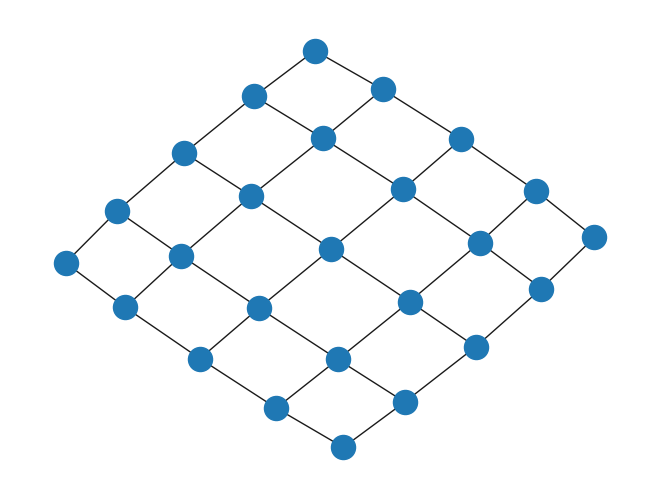

In [93]:
grid = nx.cartesian_product(nx.path_graph(5), nx.path_graph(5))
nx.draw(grid, pos=nx.spring_layout(grid))

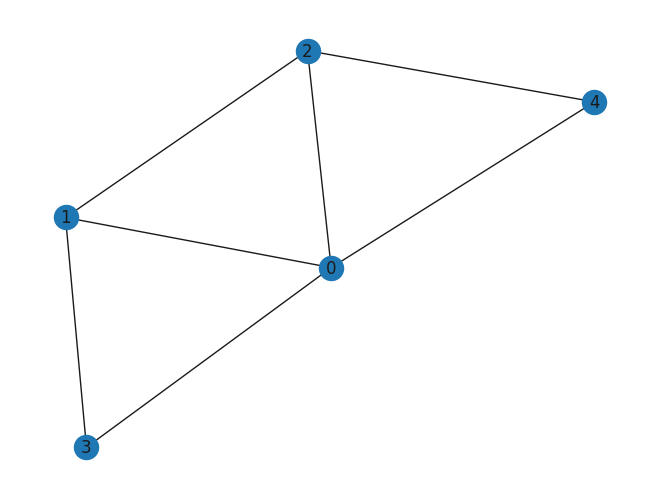

In [94]:
nNodes = 5
mEdges = 7

G0 = nx.gnm_random_graph(nNodes, mEdges)
# G0 = nx.barabasi_albert_graph(nNodes, 5)
A = nx.to_numpy_array(G0)

nx.draw(G0, labels = {x:x for x in G0.nodes()})

In [95]:
A

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 0.],
       [1., 1., 0., 0., 1.],
       [1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.]])

In [96]:
# Constraints
## Row sums
M3 = sp.sparse.kron(np.ones(nNodes), sp.sparse.eye(nNodes))
b3 = np.ones(nNodes)


## Columns sums
M4 = sp.sparse.kron(sp.sparse.eye(nNodes), np.ones(nNodes))
b4 = np.ones(nNodes)


In [105]:
M = sp.sparse.vstack([M3, M4])
M

<10x25 sparse matrix of type '<class 'numpy.float64'>'
	with 50 stored elements in COOrdinate format>

In [98]:
b = np.hstack([b3, b4])
b

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [111]:
assert all(M @ P.reshape(nNodes * nNodes) == b)

In [155]:
import functools

def objective_parametrized(A, x):
    P = x.reshape(nNodes, nNodes)
    return - np.trace(A @ P @ A.T @ P.T)

objective = functools.partial(objective_parametrized, A)

In [66]:
def perm2mat(pi):
    n = len(pi)
    ans = np.zeros((n, n))
    for i, j in enumerate(pi):
        ans[i, j] = 1

    return ans

def permmat(n):
    pi = np.random.permutation(n)
    return perm2mat(pi)


In [80]:
P = permmat(nNodes)
objective(P)

-8.0

In [116]:
from scipy.optimize import Bounds

bounds = Bounds(np.zeros(nNodes * nNodes), np.ones(nNodes * nNodes) )
bounds

Bounds(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.]))

In [119]:
from scipy.optimize import LinearConstraint

linear_constraints = LinearConstraint(M, np.ones(nNodes * 2), np.ones(nNodes * 2))
linear_constraints

In [133]:
def doubly_stochastic(P: np.ndarray, tol: float = 1e-9) -> np.ndarray:
    # Adapted from @btaba implementation
    # https://github.com/btaba/sinkhorn_knopp
    # of Sinkhorn-Knopp algorithm
    # https://projecteuclid.org/euclid.pjm/1102992505

    max_iter = 1000
    c = 1 / P.sum(axis=0)
    r = 1 / (P @ c)
    P_eps = P

    for it in range(max_iter):
        if (np.abs(P_eps.sum(axis=1) - 1) < tol).all() and (
            np.abs(P_eps.sum(axis=0) - 1) < tol
        ).all():
            # All column/row sums ~= 1 within threshold
            break

        c = 1 / (r @ P)
        r = 1 / (P @ c)
        P_eps = r[:, None] * P * c

    return P_eps

In [149]:
D = doubly_stochastic(np.random.rand(nNodes, nNodes))
P_0 = D.reshape(nNodes * nNodes)
M @ P_0

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [152]:
G = -sp.sparse.kron(A, A) - sp.sparse.kron(A.transpose(), A) # P n^2 x n^2

In [154]:
G.todense()

matrix([[ 0.,  0.,  0.,  0.,  0.,  0., -2., -2., -2., -2.,  0., -2., -2.,
         -2., -2.,  0., -2., -2., -2., -2.,  0., -2., -2., -2., -2.],
        [ 0.,  0.,  0.,  0.,  0., -2.,  0., -2., -2.,  0., -2.,  0., -2.,
         -2.,  0., -2.,  0., -2., -2.,  0., -2.,  0., -2., -2.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -2., -2.,  0.,  0., -2., -2., -2.,  0.,
          0., -2., -2., -2.,  0.,  0., -2., -2., -2.,  0.,  0., -2.],
        [ 0.,  0.,  0.,  0.,  0., -2., -2.,  0.,  0.,  0., -2., -2.,  0.,
          0.,  0., -2., -2.,  0.,  0.,  0., -2., -2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -2.,  0., -2.,  0.,  0., -2.,  0., -2.,
          0.,  0., -2.,  0., -2.,  0.,  0., -2.,  0., -2.,  0.,  0.],
        [ 0., -2., -2., -2., -2.,  0.,  0.,  0.,  0.,  0.,  0., -2., -2.,
         -2., -2.,  0., -2., -2., -2., -2.,  0.,  0.,  0.,  0.,  0.],
        [-2.,  0., -2., -2.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0., -2.,
         -2.,  0., -2.,  0., -2., -2.,  0.,  0.,  0.,  0.,  0.

In [156]:
from scipy.optimize import minimize
res = minimize(objective, P_0, method='trust-constr',
               constraints=[linear_constraints],
               options={'verbose': 1}, bounds=bounds)

`gtol` termination condition is satisfied.
Number of iterations: 41, function evaluations: 962, CG iterations: 93, optimality: 4.94e-09, constraint violation: 4.44e-16, execution time: 0.39 s.


In [161]:
P_res = res.x.reshape(nNodes, nNodes)
P_res

array([[9.99920022e-01, 2.63295721e-05, 2.80555910e-05, 1.80489259e-05,
        7.54344143e-06],
       [3.03272792e-05, 1.84267681e-05, 9.99844138e-01, 9.09572077e-05,
        1.61511666e-05],
       [9.40024184e-06, 9.99838061e-01, 2.02755675e-05, 2.77349088e-05,
        1.04527819e-04],
       [1.90715832e-05, 1.04354273e-04, 2.79335141e-05, 8.09228905e-07,
        9.99847831e-01],
       [2.11784263e-05, 1.28279241e-05, 7.95977490e-05, 9.99862450e-01,
        2.39461720e-05]])

In [162]:
from scipy.optimize import linear_sum_assignment
linear_sum_assignment(-P)

(array([0, 1, 2, 3, 4]), array([1, 0, 4, 2, 3]))